# **COMP3670/6670 Assignment 3 - GMM**
---

**Enter Your Student ID:** u7235649

**Your Name:** Han Zhang
    

**Submit:** You can write your answers in this file and submit a single Jupyter Notebook file (.ipynb) on Wattle. Rename this file with your student number as 'uXXXXXXX.ipynb'. Otherwise, you can write your programming questions in this file, and submit two files, 'uXXXXXXX.ipynb' for programming and 'uXXXXXXX.pdf' for theory. Please submit them separately instead of a zip file.
    
**Enter Discussion Partner IDs Below:**
- <Enter ID 1> u6908560
- <Enter ID 2>
- <Enter ID 3>
    

**Programming Section**
- 1 = 20%
- 2 = 20%
- 3 = 20%
- 4 = 7.5%
- 5 = 7.5%
- 6.1 = 5%
- 6.2 = 20%

---


**PROGRAMMING SECTION**
---


For all of the following, program the solution yourself. Don't just call a library function that does the whole question for you, or you'll get zero (no, that doesn't mean you can't use any library functions, but it does mean that you have to show you understand how to compute the answer yourself).

-----------

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #This is for 3d scatter plots.
import math
import random
import functools

We're going to implement an algorithm to model data with a mixture of gaussians. 

Remember the simplified EM algorithm in assignment 2 for k-means? Well, we're going to implement something similar.

The more complex aspect of this all is that your program must also correctly estimate the covariance matrices of the 2-dimensional gaussian components involved, as well as their means.

Not only this, but the "distance" of each of your data points (a row $d_i$ of $D$) from a gaussian $k$, is the probability of that point given that gaussian $p(d_i \mid k)$. 

Run the below cell to load the data we'll be using.

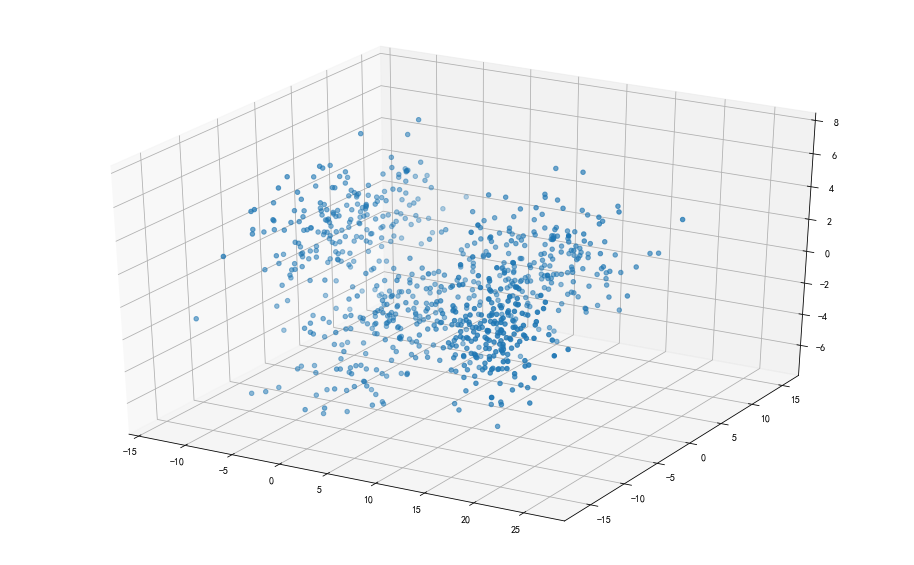

In [17]:
X = np.load("./data.npy")
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:, 2])
plt.show()

First off, some definitions:

$X$ is a dataset contains 800 data. Each data has 5 dimensions. The contribution of first three dimensions represented by a three dimensional Gaussian Mixture Model. The forth and fifth dimensions represented by another two dimensional GMM. 

**You only need the first three dimensions of the data in task 1 through 5. The fourth and fifth dimensions are for task 6 only.**.

$K$ is the total number of gaussians. This is just like the $K$ means you had for k-means in assignment 2. Each gaussian is named $k$, where $k$ is the unique number associated with that gaussian. For example, the first gaussian is $k = 1$. Each $k$ has a mean and covariance matrix associated with it. This allows you to construct a gaussian which is just a formula which can be used to generate data points or to compute the probability that a given data point is generated from this gaussian (look up generative models if you're curious to learn more). For this purpose, you can use np.random.multivariate_normal().

$\Sigma$ is a list of covariance matrices $\Sigma_k \in \mathbb{R}^{m \times m}$, which are symmetric positive semidefinite matrices.

$\mu$ is a list of means, each one $\mu_k \in \mathbb{R}^{m}$ associated with gaussian $k$.

$N$ is the total number of datapoints.

$responsibilities \in [0, 1]^{N \times K}$ is a matrix. Every column $k$ of $responsibilities$ is associated with the $k^{th}$ gaussian. Each element $r_{ik}$ of the $k^{th}$ column is the probability of the $i^{th}$ datapoint $x_i$ (the $i^{th}$ row of $X$) given the gaussian $k$.

$N_k$ is the sum of the $k^{th}$ column of $responsibilities$. In other words, there is one $N_k$ for each gaussian. $N_k = \sum_i r_{ik}$.

$\pi$ is a list of probabilities, 1 associated with each gaussian. $\pi_k$ is the probability of gaussian $k$. $\pi_k = \frac{N_k}{N}$.

---

   **TASK 1:** Complete the below function to initialise your parameters. You will need to generate:
   1. A list $\mu$ of $K$ means, each of which is in $\mathbb{R}^{m}$.
   2. A list $\Sigma$ of $K$ covariance matrices in $\mathbb{R}^{m \times m}$. Remember, covariance matrices must be symmetric positive semidefinite.
   3. A list $\pi$ of $K$ probabilities $\pi_k$. They should be initialised at $\frac{1}{K}$ (uniformly distributed at first).

Do not hard code parameters. You should generate them with some randomness, and your code must work for any $m$, $k$ and $N$.

You need to intelligently select $\mu_k$ just like you did with k-means. Poorly initialised parameters may result in an entirely broken EM algorithm.

**REPEAT: You only need the first three dimensions of the data in task 1 through 5. The fourth and fifth dimensions are for task 6 only.**.

---

In [41]:
def initialise_parameters(X, K):
    # YOUR CODE HERE
#     print(X)
    row, col = X.shape
    
    sigma = []
    X_mean = np.mean(X, axis=0)
    X_minus = np.zeros((row, col))
    X_minus[:] = X[:] - X_mean
    cov = np.zeros((col, col))
    for i in range(col):
        for j in range(col):
            cov[i, j] = X_minus[:, i]@X_minus[:, j].T/(row-1)
    
    
    mu = []
#     mu_index = []
    counter = 0        # how much mu have been choosen
    while counter < K:
        i = np.random.randint(row)
        x = X[i]
        
        choosen = False      # if this point has been choosen
        for m in mu:         # check if this point is choosen
            counter_ = 0     # counter of the same bits
            for n in range(col):
                if x[n] == m[n]:
                    counter_ += 1
            if counter_ == K:
                choosen = True
        
        if not choosen:
            mu.append(X[i])
            sigma.append(cov)
            counter += 1
            
#         if i not in mu_index:
#             mu_index.append(i)
#             mu.append(X[i])             # append mu
#             sigma.append(cov)           # append sigma
#             counter += 1

    
    pi = [1/K for _ in range(K)]
    return np.array(sigma), np.array(mu), np.array(pi)
    
K = 4
sigma, mu, pi = initialise_parameters(X[:, :3], K)
print('\nSigma: \n', sigma)
print('\nMu: \n', mu)
print('\nPi: \n', pi)


Sigma: 
 [[[ 91.95813573 -19.47669718  -0.11234746]
  [-19.47669718  37.13754844   3.92447478]
  [ -0.11234746   3.92447478   7.00375292]]

 [[ 91.95813573 -19.47669718  -0.11234746]
  [-19.47669718  37.13754844   3.92447478]
  [ -0.11234746   3.92447478   7.00375292]]

 [[ 91.95813573 -19.47669718  -0.11234746]
  [-19.47669718  37.13754844   3.92447478]
  [ -0.11234746   3.92447478   7.00375292]]

 [[ 91.95813573 -19.47669718  -0.11234746]
  [-19.47669718  37.13754844   3.92447478]
  [ -0.11234746   3.92447478   7.00375292]]]

Mu: 
 [[ 13.01036168 -10.42765003  -1.72662362]
 [ 14.61197275 -10.79938342  -1.58859328]
 [ 22.03891058   0.35213302   0.39868416]
 [ -8.97640294   1.33056384   0.17803276]]

Pi: 
 [0.25 0.25 0.25 0.25]


$E\_step$ computes the matrix $responsibilities \in [0, 1]^{N \times K}$, where $N$ is the number of data points, and $K$ is the number of gaussians you're attempting to cluster the data with. Each gaussian will be associated with a column of $responsibilities$. As your algorithm runs, each row represents a data point $x_i$, and each column of that row will contain the probability that $x_i$ came from that gaussian, $p(x_i \mid k)$, signifying the extent to which this datapoint $x_i$ has been assigned to the gaussian associated with that column. 

---

**TASK 2:** Implement $E\_step(\pi, \mu, \Sigma, X) = responsibilities$, which updates the $responsibilities$ matrix.

Remember, which gaussian a datapoint is assigned to depends on the probability of that datapoint given that gaussian.

You cannot use euclidean distance like you did with the k-means algorithm in assignment 3.

**HINT:** 
- Each element of responsibilities $r_{ik} = \frac{\pi_k \mathcal{N}(x_i \mid \mu_k \Sigma_k)}{\sum_j \pi_j \mathcal{N}(x_i \mid \mu_j \Sigma_j)}$, where $x_i$ is the $i^{th}$ row of $X$.
- https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html
- Use $multivariate\_normal.pdf(x, \mu_k, \Sigma_k)$

---

In [4]:
from scipy.stats import multivariate_normal

def E_step(pi, mu, sigma, X):
    # YOUR CODE HERE
    
    K = len(pi)
    row, col = X.shape

#     r = np.zeros((row, K))
    g = np.zeros((row, K))
#     print(g.shape)

#     print(r_k)
    for k in range(K):
        pi_k = pi[k]
        mu_k = mu[k]
        sigma_k = sigma[k]
        for i in range(row):
            g[i, k] = multivariate_normal.pdf(X[i], mean=mu_k, cov=sigma_k) * pi_k
#     print(g.sum(axis=1).shape)
    g_sum = g.sum(axis=1)
    r = np.zeros_like(g)
    for index in range(row):
        r[index] = g[index] / g_sum[index]
    return r

responsibilities = E_step(pi, mu, sigma, X[:, :3])
print(responsibilities)

[[0.01363447 0.10969477 0.53458006 0.3420907 ]
 [0.00144183 0.01721137 0.11443816 0.86690864]
 [0.00191796 0.01832119 0.39614401 0.58361684]
 ...
 [0.07936079 0.0558708  0.85357557 0.01119284]
 [0.07017136 0.04460688 0.8717394  0.01348237]
 [0.03433829 0.01407575 0.95047687 0.00110909]]


---

**TASK 3:** Implement $M\_step(responsibilities, X) = \mu, \Sigma, \pi$ which returns the updated means and covariances for all of the $k$ gaussians, along with the priors $\pi$.

**HINT:** 
- https://docs.scipy.org/doc/numpy/reference/generated/numpy.outer.html

---

In [5]:
def M_step(r, X):
    # YOUR CODE HERE
    _, K = r.shape
    row, col = X.shape
    
    N = r.sum(axis=0)
#     print(N)


    mu = np.zeros((K, col))
    sigma = []
    pi = np.zeros(K)
    
    for k in range(K):
        
        # mu:
        mu[k] = np.array([r[:, k]*X[:, i] for i in range(col)]).sum(axis=1)/N[k]

#         mu_sums=[]
        
#         for n in range(row):
#             r_nk = r[n, k]
#             x_n = X[n]
#             mu_sums.append(r_nk*x_n)
            
#         mu_sums = np.array(mu_sums)
# #         print(sums.shape)
#         mu[k] = mu_sums.sum(axis=0)/N[k]
        
    
        # sigma:
        sigma_sums = np.zeros((col, col))
        for n in range(row):
            x_n = X[n]
            minus = (x_n-mu[k]).reshape((col, 1))
            r_nk = r[n, k]
            sigma_sums = sigma_sums + minus@minus.T*r_nk
        sigma.append(sigma_sums / N[k]) 
#         print(sigma[k])
        
        # pi:
        pi[k] = N[k] / row
        
    sigma = np.array(sigma)
    return mu, sigma, pi

# print('\nMu1: \n', mu)

mu, sigma, pi = M_step(responsibilities, X[:, :3])
print('\nSigma: \n', sigma)
print('\nMu: \n', mu)
print('\nPi: \n', pi)


Sigma: 
 [[[53.83046778 -2.1462395  -0.48652653]
  [-2.1462395  20.12878564  3.2496287 ]
  [-0.48652653  3.2496287   5.50555615]]

 [[53.55065161 -3.30646304 -3.55748171]
  [-3.30646304 23.5853756   3.9791463 ]
  [-3.55748171  3.9791463   7.06668778]]

 [[55.09674533 -2.10978358  7.09192706]
  [-2.10978358 32.08984846  6.10760381]
  [ 7.09192706  6.10760381  5.78364469]]

 [[29.22234323 -9.04693863  1.14983633]
  [-9.04693863 11.44577995  1.17272227]
  [ 1.14983633  1.17272227  4.06656348]]]

Mu: 
 [[ -1.67212929   2.19631926   1.03785868]
 [ -2.91591884  -2.21215948   1.02286257]
 [  7.80669298  -1.9582907   -1.1990577 ]
 [ 15.86791072 -10.06047106   0.95200748]]

Pi: 
 [0.14373043 0.2195963  0.49256464 0.14410863]


---

**TASK 4:** Implement $classify(\pi, \mu, \Sigma, x) = k$ which takes an unknown example $x \in \mathbb{R}^{m}$, the means $\mu$ and covariance matrices $\Sigma$ and the priors $\pi$, and returns $k$, the number of the gaussian which maximises the probability of $x$.

In other words, ${arg max}_k \left(p(x \mid \mu_k, \Sigma_k)\pi_k \right)$.

---

In [16]:
def classify(pi, mu, sigma, x):
    # YOUR CODE HERE
    k = pi.shape[0]
    r = E_step(pi, mu, sigma, x.reshape((x.shape[0], 1)).T).reshape(k)
#     print(r)
    max_k = 0
    for i in range(k):
        if r[i] > r[max_k]:
            max_k = i
    return max_k
#     return -1

print(classify(pi, mu, sigma, X[270, :3]))

1


---

**TASK 5:** Implement $EM(X, K, iterations) = \mu, \Sigma, \pi$ which: 
1. takes a dataset $X \in \mathbb{R}^{N \times m}$ and $K$, an integer indicating how many gaussians will be used to cluster the data, and $iterations$ the number of iterations to be performed.
2. uses all of the functions you completed above to initialise parameters and find the optimal means $\mu$, covariances $\Sigma$ and priors $\pi$ to cluster the data points (a gaussian mixture model).

---


Sigma: 
 [[[ 1.90820239e+01  1.86159494e-02  2.83934120e+00]
  [ 1.86159494e-02  2.15412798e+00  7.35930092e-02]
  [ 2.83934120e+00  7.35930092e-02  4.72767084e+00]]

 [[ 1.34762384e+01 -5.19010524e+00  2.11125295e+00]
  [-5.19010524e+00  3.27650537e+00 -5.40917681e-01]
  [ 2.11125295e+00 -5.40917681e-01  4.58630462e+00]]

 [[ 2.35890794e+00  4.80930966e+00  7.93283091e-01]
  [ 4.80930966e+00  2.52431418e+01 -9.85279232e-01]
  [ 7.93283091e-01 -9.85279232e-01  4.48846589e+00]]

 [[ 1.35887681e+01  4.45121906e+00  1.67419693e+00]
  [ 4.45121906e+00  1.61981561e+01  4.49357089e+00]
  [ 1.67419693e+00  4.49357089e+00  3.38257342e+00]]]

Mu: 
 [[ 11.55727559   2.96851563   0.65106382]
 [ 15.60669028 -10.25437175  -0.07105923]
 [ -7.12757751   0.65760616   1.77505015]
 [  1.12236984  -3.60531598  -2.68887936]]

Pi: 
 [0.24603831 0.25178625 0.25277327 0.24940217]


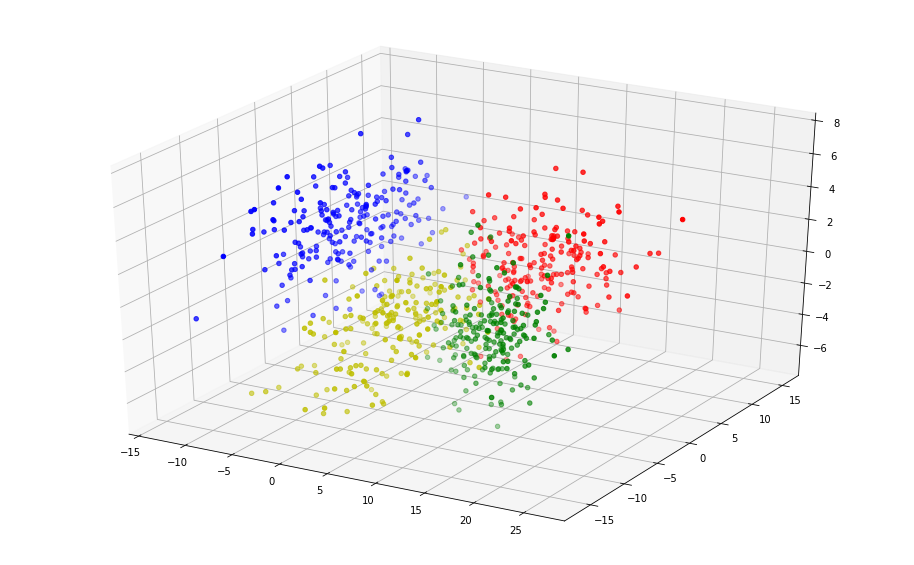

In [17]:
def EM(X, K, iterations):
    # YOUR CODE HERE
    sigma, mu, pi = initialise_parameters(X, K)
    for _ in range(iterations):
        r = E_step(pi, mu, sigma, X)
        mu, sigma, pi = M_step(r, X)
#     print(pi.shape)
    return mu, sigma, pi


#Test code. Leave it aloooooone!
iterations = 30
K = 4
mu_1, sigma_1, pi_1 = EM(X[:, :3], K, iterations)
print('\nSigma: \n', sigma_1)
print('\nMu: \n', mu_1)
print('\nPi: \n', pi_1)

def allocator(pi, mu, sigma, X, k):
    N = X.shape[0]
    cluster = []
    for ix in range(N):
        prospective_k = classify(pi, mu, sigma, X[ix, :])
        if prospective_k == k:
            cluster.append(X[ix, :])
    return np.asarray(cluster)

colours = ['r', 'g', 'b', 'y']
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
for k in range(K):
    cluster = allocator(pi_1, mu_1, sigma_1, X[:, :3], k)
    ax.scatter(cluster[:,0], cluster[:,1], cluster[:, 2], c=colours[k])
plt.show()

Now we start to use the forth and fifth dimension. First, we plot the forth and fifth dimension.

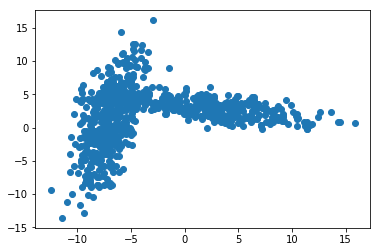

In [18]:
plt.scatter(X[:,3], X[:,4])
plt.show()

It is clearly that the number of Gaussians (K) for the second GMM equals to 2.

**TASK 6.1:** Compute the $\mu, \pi, \Sigma$ of the second GMM

In [23]:
mu_2, sigma_2, pi_2 = EM(X[:, 3:], 2, 50)

In [26]:
# def allocator(pi, mu, sigma, X, k):
#     N = X.shape[0]
#     cluster = []
#     for ix in range(N):
#         prospective_k = classify(pi, mu, sigma, X[ix, :])
#         if prospective_k == k:
#             cluster.append(X[ix, :])
#     return np.asarray(cluster)

# colours = ['r', 'g']
# fig = plt.figure(figsize=(16, 10))
# ax = fig.add_subplot(111)
# print(mu_2)
# for k in range(2):
#     cluster = allocator(pi_2, mu_2, sigma_2, X[:, 3:], k)
#     ax.scatter(cluster[:,0], cluster[:,1], c=colours[k])
# plt.show()

**TASK 6.2:** Conditional Distribution.

Using the function from the Task 4. Using the $\mu, \pi, \Sigma$ to calculate the conditional distribution.

Let $K$ stands for the classification result of the first three dimensions, $Y$ stands for the classification result of the second dimensions.

Possible $k$ values are 0, 1, 2, 3. Possible $y$ values are 0, 1. 

Compute the conditional distribution $p(Y = y|K = k)$.

In [59]:
def conditional_distribution(X, k, y, mu_1, pi_1, sigma_1, mu_2, pi_2, sigma_2):
    # YOUR CODE HERE
    row, col = X.shape
    K = len(pi_1)
    classifies = np.zeros((row, 2))
    for i in range(row):
        x1 = X[i, :3]
        x2 = X[i, 3:]
        classifies[i, 0] = classify(pi_1, mu_1, sigma_1, x1)
        classifies[i, 1] = classify(pi_2, mu_2, sigma_2, x2)

    k_ = classifies[classifies[:, 0] == k]
    y_ = k_[k_[:, 1] == y]
    
#     print(k_.shape)           
#     print(y_.shape)
    return len(y_) / len(k_)

In [62]:
a = conditional_distribution(X, 0, 0, mu_1, pi_1, sigma_1, mu_2, pi_2, sigma_2)
b = conditional_distribution(X, 0, 1, mu_1, pi_1, sigma_1, mu_2, pi_2, sigma_2)
print(a + b) # The answer should equal(or almost equal) to one.

1.0


---
# Theory




## Question 1 Continuous Bayesian Inference

### a)

$p(\theta|x_{1:n}=1^n)$
$=\frac{p(x_{1:n} = 1^n|\theta)p(\theta)}{p(x_{1:n} = 1^n)}$
$=\frac{\theta^n p(\theta)}{\int^1_0p(x_{1:n}=1^n|\theta)p(\theta)d\theta}$
$=\frac{\theta^n p(\theta)}{\int^1_0\theta^n p(\theta)d\theta}$

### b)

$p(\theta|x_{1:n}=0^n)=\frac{p(x_{1:n}=0^n|\theta)p(\theta)}{\int^1_0p(x_{1:n}=0^n|\theta)p(\theta)d\theta}$
$=\frac{(1-\theta)^np(\theta)}{\int^1_0(1-\theta)^np(\theta)d\theta}$


### c)

$p(\theta|x_{1:n}=1^n)=\frac{\theta^n}{\int^1_0\theta^n d\theta}$
$=\frac{\theta^n}{1/(n+1)}$
$=\theta^n(n+1)$

### d)

$\mu_n=\int^1_0\theta p(\theta|x_{1:n}=1^n)d\theta$
$=\int^1_0\theta\theta^n(n+1)d\theta$
$=\int^1_0\theta^{n+1}(n+1)d\theta$
$=\frac{n+1}{n+2}$

As $n\rightarrow\infty$, $\mu_n$ will be closer to 1.

### e)

$\sigma^2_n$   
$=E[(\theta-\mu_n)^2]$  
$=\int^1_0(\theta-\mu_n)^2p(\theta|x_{1:n}=1^n)d\theta$  
$=\int^1_0(\theta-\frac{n+1}{n+2})^2\theta^n(n+1)d\theta$  
$=(n+1)(\frac{1}{n+3}-\frac{2n+2}{(n+2)^2}+\frac{1}{n^2+4n+4}(\frac{n^2}{n+1}+\frac{2n}{n+1}+\frac{1}{n+1}))$

As $n\rightarrow\infty$, the observed $\theta$ and the real one will become closer and closer.

### f)

$\theta_{MAP_n}=arg_\theta maxf(x_{1:n}=1|\theta)p(\theta)$  
$MAP=\theta^n(n+1)$

While $0\leq\theta\leq1$, $\theta_{MAP_n}=1$

As $n\rightarrow\infty$, it will not change. 

### g)

$\mu_n$. The observed situation does not fully reflect the true $\theta$. The value of $\mu_n$ will gradually approach 1 as n increases, while $\theta_{MAP}$ will not.

### h)

As plotted below.

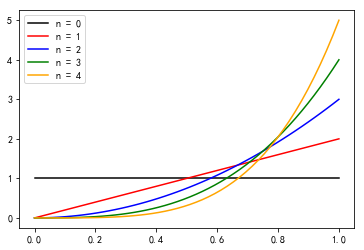

In [14]:
def getP(theta, n):
    return theta ** n * (n + 1)

theta = theta = np.linspace(0,1)

n0 = getP(theta, 0)
n1 = getP(theta, 1)
n2 = getP(theta, 2)
n3 = getP(theta, 3)
n4 = getP(theta, 4)

plt.plot(theta,n0,color='black',label='n = 0')
plt.plot(theta,n1,color='red',label='n = 1')
plt.plot(theta,n2,color='blue',label='n = 2')
plt.plot(theta,n3,color='green',label='n = 3')
plt.plot(theta,n4,color='orange',label='n = 4')

plt.legend()
plt.show()



## Question 2 Bayesian Inference on Imperfect Information

### a)

When $\alpha=\beta=1$: the camera will always report the right result. The posterior of $\theta$ will be very close to the real one.

When $\alpha=\beta=1/2$: the camera has a half chance of reporting the correct result, and a half chance of reporting the wrong result.

When $\alpha=\beta=0$: the camera will always report the wrong result. The posterior and actual values are almost inverse.


### b)

$p(\hat{X}=0|\theta)$  
$=p(X=0,\hat{X}=0|\theta)+p(X=1,\hat{X}=0|\theta)$  
$=(1-\theta)\alpha+\theta(1-\beta)$  
$=\alpha-\theta\alpha+\theta-\theta\beta$  

$p(\hat{X}=1|\theta)$  
$=p(X=0,\hat{X}=1|\theta)+p(X=1,\hat{X}=1|\theta)$  
$=(1-\theta)(1-\alpha)+\theta\beta$  
$=1-\alpha-\theta+\theta\alpha+\theta\beta$

### c)

$p(\theta|\hat{X}=1)$  
$=\frac{p(\hat{X}=1|\theta)p(\theta)}{\int^1_0p(\hat{X}=1|\theta)p(\theta)d\theta}$  
$=\frac{(1-\alpha-\theta+\theta\alpha+\theta\beta)p(\theta)}{\int^1_0(1-\alpha-\theta+\theta\alpha+\theta\beta)p(\theta)d\theta}$

When $\alpha=\beta=1$:  
$p(\theta|\hat{X}=1)=\frac{\theta p(\theta)}{\int^1_0\theta p(\theta)d\theta}$

When $\alpha=\beta=1/2$:   
$p(\theta|\hat{X}=1)=\frac{p(\theta)}{\int^1_0p(\theta)d\theta}$

When $\alpha=\beta=0$:   
$p(\theta|\hat{X}=1)=\frac{(1-\theta)p(\theta)}{\int^1_0(1-\theta)p(\theta)d\theta}$

While $\alpha=\beta=1$ and $\alpha=\beta=0$, the posterior is depended on $\theta$. While $\alpha=\beta=1/2$, the posterior is not depended on $\theta$ because the observed result is random.

### d）

$p(\theta|\hat{X}=1)$  
$=\frac{1-\alpha-\theta+\alpha\theta+\alpha\theta}{\int^1_0(1-\alpha-\theta+\alpha\theta+\alpha\theta)d\theta}$  
$=\frac{1-\alpha-\theta+2\alpha\theta}{\int^1_0(1-\alpha-\theta+2\alpha\theta)d\theta}$  
$=2-2\alpha-2\theta+4\alpha\theta$

### e)

As plotted below,

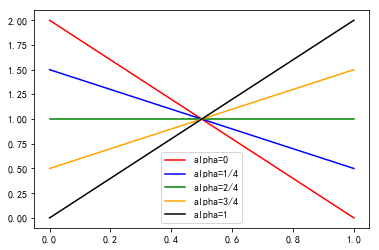

In [42]:
def getP(theta, a):
    return 2-2*a-2*theta+4*a*theta

theta = np.linspace(0,1)

a1 = getP(theta, 0)
a2 = getP(theta, 1/4)
a3 = getP(theta, 2/4)
a4 = getP(theta, 3/4)
a5 = getP(theta, 1)

plt.plot(theta,a1,color='red',label='alpha=0')
plt.plot(theta,a2,color='blue',label='alpha=1/4')
plt.plot(theta,a3,color='green',label='alpha=2/4')
plt.plot(theta,a4,color='orange',label='alpha=3/4')
plt.plot(theta,a5,color='black',label='alpha=1')

plt.legend()
plt.show()

## Question 3 Relating Random Variables

### a)

$F_Y(y)=P(Y\leq y)=P(\frac{1}{X}<y)=P(X\geq\frac{1}{y})=1-P(X\leq\frac{1}{y})=1-F_X(\frac{1}{y})$

$p_Y(y)=\frac{d}{dy}(1-F_X(\frac{1}{y}))=-\frac{dF_X(\frac{1}{y})}{d\frac{1}{y}}\frac{d\frac{1}{y}}{dy}=p_X(\frac{1}{y})(-\frac{1}{y})$  
$=\frac{1}{y^2}p_X(\frac{1}{y})$

### b)

$profit=\left\{\begin{aligned}
m-1&,& 1\leq m<y \\
-1&,& m\geq y
\end{aligned}\right.$

Expected profit  
$E(profit)=(-1)P(m\geq y)+(m-1)P(1\leq m<y)$  
$=-(1-P(1\leq m<y))+(m-1)P(1\leq m<y)$  
$=-1+P(1\leq m<y)+(m-1)P(1\leq m<y)$  
$=mP(1\leq m<y)-1$  
$=mP(0\leq x<\frac{1}{m})-1$  
$=m\int^{\frac{1}{m}}_0p_X(x)dx-1$

### c)

With the given $p_X(x)$,    
$E(profit)=m\int^{\frac{1}{m}}_0dx-1=0$  
$\frac{d}{dm}E(profit)=0$

So the player can randomly guess a number, the expected profit will always be 0.

### d)

$p_X(x)=\left\{\begin{aligned}
B+1&& 0<x<\frac{1}{B+1} \\
0&& otherwise
\end{aligned}\right.$

So that $c>B+1$. If $m\geq B+1$, $E(profit)=m\int^{\frac{1}{B+1}}_0B+1dx-1=m-1>B$.

Since that if c is always greater than a number, then the expected profit is predictable.